In [1]:
import sys; sys.path.insert(0, '../');
from ccqe_notebook_tools import *
# %matplotlib inline
%matplotlib notebook
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))
# redirect output to the systems standard output 
sys.stdout = open('/dev/stdout', 'w')

In [2]:
File = ROOT.TFile("/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TracksAnaFiles/Events_MCC7_MC_BNB_2TracksClusters.root")
# File = ROOT.TFile("/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TracksAnaFiles/Events_MCC7_ExampleDebugging_2TracksClusters.root")
tree = File.Get("TwoTracksTree")
events = AnalyzeVertex( tree )

In [3]:
# global constants
distance_threshold=200 # mm
angular_tracking_diff_max=1.046  # 0.523 rad. = 30 deg.

In [4]:
def plot_hits(hits,plane,ax=None):
    hit_wire, hit_time, hit_charge , hit_number  = [] , [] , [] , []
    # hits in this plane
    for i_hit,hit in enumerate(hits):
        if hit.hit_plane==plane:
            hit_number.append(i_hit)
            hit_wire.append(hit.hit_wire)
            hit_time.append(hit.hit_peakT)
            hit_charge.append(hit.hit_charge)
    if ax is not None:
        ax.scatter(hit_wire,hit_time,c=hit_charge, vmin=np.min(hit_charge), vmax=np.max(hit_charge),cmap='hot_r')
    return hit_wire, hit_time, hit_charge , hit_number

In [5]:
def get_t_start_end(t,plane): # t is a track
    if plane==0:    
        t_start_wire,t_start_time = t.start_wire_u, t.start_time_u                
        t_end_wire,t_end_time = t.end_wire_u, t.end_time_u
    elif plane==1:                
        t_start_wire,t_start_time = t.start_wire_v, t.start_time_v                                    
        t_end_wire,t_end_time = t.end_wire_v, t.end_time_v                
    elif plane==2:                            
        t_start_wire,t_start_time = t.start_wire_y, t.start_time_y                                    
        t_end_wire,t_end_time = t.end_wire_y, t.end_time_y            
    return t_start_wire , t_start_time , t_end_wire , t_end_time

In [6]:
def print_my_tracks(my_tracks):
    for my_track in my_tracks:
        print my_track['pandoraNu_track'].track_id , my_track['pandoraNu_track'].MCpdgCode
        for i,hit in enumerate(my_track['hits']):
            print i,hit.hit_wire,hit.hit_peakT

In [7]:
def plot_my_tracks(fig=None,hits=None , tracks=None , my_tracks=None , figsize=None , fontsize=None , plane=0, MCmode=True , do_add_numbers=False , debug=0 ):
    
    ax = fig.add_subplot(1,3,plane+1); ax.set_title('%s plane'%('u' if plane==0 else 'v' if plane==1 else 'y'),y=0.95)
    hit_wire, hit_time, hit_charge , hit_number = plot_hits(hits=hits,plane=plane,ax=ax)
    t_start_wire_min , t_end_wire_max , t_start_time_min , t_end_time_max= 8256 , 0 , 9500 , 0

    for t in tracks:
        color, label = set_color_label(t.MCpdgCode,MCmode=MCmode)
        t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(t,plane)
        ax.plot( [t_start_wire,t_end_wire] , [t_start_time,t_end_time] ,label='track %d '%t.track_id+label, color=color,alpha=0.5)
            
        t_start_wire_min = np.min([t_start_wire , t_end_wire , t_start_wire_min])
        t_end_wire_max   = np.max([t_start_wire , t_end_wire , t_end_wire_max])
        t_start_time_min = np.min([t_start_time , t_end_time , t_start_time_min])
        t_end_time_max   = np.max([t_start_time , t_end_time , t_end_time_max])

        # TRACKs boxes
        if debug>1:
            box = enlarge_box(box=[ t_start_wire , t_end_wire , t_start_time , t_end_time ])
            ax.add_patch( patches.Rectangle( (t_start_wire, t_start_time), (t_end_wire-t_start_wire) , (t_end_time-t_start_time) , color=color , alpha=0.6,fill=False) )


    for my_track in my_tracks:
        hits_wire , hits_time , hit_charge , hit_number = plot_hits(my_track['hits'],plane)        
        ax.scatter(hits_wire , hits_time , c=my_track['color'])
        if do_add_numbers: 
            for w,t,n in zip(hits_wire , hits_time, hit_number): ax.text( w , t , n )
                
    # CC1p ROI
    ax.add_patch( patches.Rectangle( (t_start_wire_min, t_start_time_min), (t_end_wire_max-t_start_wire_min) , (t_end_time_max-t_start_time_min) ,fill=False) )


    ax.set_xlim( t_start_wire_min - 8 , t_end_wire_max + 8 )
    ax.set_ylim( t_start_time_min - 20 , t_end_time_max + 20 )
    ax.xaxis.set_major_locator(LinearLocator(3));ax.yaxis.set_major_locator(LinearLocator(3))
    set_axes(ax,x_label='wire',y_label='peak-time' if plane==0 else '',fontsize=fontsize)
    v_wire, v_time = find_vertex_location(plane,tracks)
    ax.scatter( v_wire, v_time , c='green', s=50 , alpha=0.3)
    ax.grid(linestyle='--',alpha=0.5,which='both')
    if plane!=0 and debug<2: ax.yaxis.set_major_formatter( NullFormatter() )
    if MCmode and plane==0: ax.legend(loc='best',fontsize=fontsize)

In [8]:
def distance( r1 , r2 ):
    # return the distance in mm
    [w1 , t1] = r1
    [w2 , t2] = r2
    # pitch between wires is 3 mm
    wire_distance = float(w1-w2)*3. 
    # drift velocity ~ 1.114 mm/us = 0.557 mm/time-tick  (2 time ticks = 1 us)
    # so dt * 0.557 = dx [mm]
    time_distance = float(t1-t2)*0.557 
    # print 'wire_distance:',wire_distance,',time_distance',time_distance
    return np.sqrt( np.square(wire_distance) + np.square(time_distance) )

def find_vertex_location(plane,tracks):
    t1_sw , t1_st , t1_ew , t1_et = get_t_start_end(tracks[0],plane)
    t2_sw , t2_st , t2_ew , t2_et = get_t_start_end(tracks[1],plane)
    start_start_distance = distance( [t1_sw,t1_st] , [t2_sw , t2_st] )
    start_end_distance   = distance( [t1_sw,t1_st] , [t2_ew , t2_et] )
    end_start_distance   = distance( [t1_ew,t1_et] , [t2_sw , t2_st] )
    end_end_distance     = distance( [t1_ew,t1_et] , [t2_ew , t2_et] )

    min_distance = np.min([start_start_distance , start_end_distance , end_start_distance , end_end_distance ])

    if start_start_distance==min_distance: return 0.5*(t1_sw + t2_sw) , 0.5*(t1_st + t2_st)  
    if start_end_distance==min_distance: return 0.5*(t1_sw + t2_ew) , 0.5*(t1_st + t2_et)  
    if end_start_distance==min_distance: return 0.5*(t1_ew + t2_sw) , 0.5*(t1_et + t2_st)  
    if end_end_distance==min_distance: return 0.5*(t1_ew + t2_ew) , 0.5*(t1_et + t2_et)  
    
def hit_hit_distance(hit1,hit2):
    return distance([hit1.hit_wire,hit1.hit_peakT],[hit2.hit_wire,hit2.hit_peakT])

def hit_hit_angle(hit1,hit2):
    return np.arctan2( hit2.hit_peakT - hit1.hit_peakT , hit2.hit_wire - hit1.hit_wire )

In [9]:
def find_closest_hit_to_vertex( plane=None , hits=None , vertex_wire=None , vertex_time=None ):
    closest_hit_to_vertex = None 
    distace_closest_hit_to_vertex = 10000
    
    for hit in hits:
        distace_to_hit = distance([vertex_wire,vertex_time],[hit.hit_wire,hit.hit_peakT])
        if distace_to_hit < distace_closest_hit_to_vertex:
            distace_closest_hit_to_vertex = distace_to_hit
            closest_hit_to_vertex = hit 
    return closest_hit_to_vertex

def exist_close_hit_at_a_good_angle( closest_hit_to_vertex=None ,plane=None
                                    ,start_hit=None,hits=None ,tracks=None
                                    ,this_track_id=None
                                    ,box=None      
                                    ,track_angle=None
                                    ,threshold_start_distance=10):
    distace_to_next_hit = threshold_start_distance
    next_hit = None
    for hit in hits:
        if hit.hit_plane == plane and hit_in_box(hit,box):            
            distace_to_hit = hit_hit_distance(start_hit , hit)
            angle_to_hit = hit_hit_angle(start_hit , hit)
            if distace_to_hit < distace_to_next_hit and np.abs(angle_to_hit - track_angle)<angular_tracking_diff:
                distace_to_next_hit = distace_to_hit
                next_hit = hit
    if next_hit is not None: return True
    return False

In [10]:
def hit_in_box( hit , box ):
    [ w1 , w2 , t1 , t2 ] = box
    min_wire , max_wire = np.min([w1,w2]) , np.max([w1,w2])
    min_time , max_time = np.min([t1,t2]) , np.max([t1,t2])
    if min_wire<hit.hit_wire and hit.hit_wire<max_wire and min_time<hit.hit_peakT and hit.hit_peakT<max_time:
        return True
    #print hit.hit_wire,hit.hit_peakT,'not in box',[min_wire,max_wire,min_time,max_time]
    return False

def enlarge_box(box):
    [ w1 , w2 , t1 , t2 ] = box
    min_wire , max_wire = np.min([w1,w2]) , np.max([w1,w2])
    min_time , max_time = np.min([t1,t2]) , np.max([t1,t2])
    return [min_wire-5,max_wire+5,min_time-5,max_time+5]

In [11]:
def associate_hits_to_tracks(hits,tracks,plane=0 , MCmode=True, vertex_wire=None , vertex_time=None , debug=0):
    my_tracks = []
    hit_wire, hit_time, hit_charge , hit_number = plot_hits(hits,plane)
    
    possible_start_hits = hits
    closest_hit_to_vertex = find_closest_hit_to_vertex( plane=plane , hits=possible_start_hits , vertex_wire=vertex_wire , vertex_time=vertex_time )
    if debug>1: print 'closest_hit_to_vertex:',closest_hit_to_vertex.hit_wire,closest_hit_to_vertex.hit_peakT
    if closest_hit_to_vertex is None: return
    
    for t in tracks:
        color, label = set_color_label(t.MCpdgCode,MCmode=MCmode)
        t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(t,plane)
        if distance([t_start_wire,t_start_time],[vertex_wire,vertex_time])>distance([t_end_wire,t_end_time],[vertex_wire,vertex_time]):
            tmp = t_start_wire; t_start_wire = t_end_wire; t_end_wire = tmp;
            tmp = t_start_time; t_start_time = t_end_time; t_end_time = tmp;
        min_wire , max_wire = np.min( [t_start_wire,t_end_wire] ) , np.max( [t_start_wire,t_end_wire] )
        min_time , max_time = np.min( [t_start_time,t_end_time] ) , np.max( [t_start_time,t_end_time] )
        track_angle = np.arctan2( t_end_time-t_start_time , t_end_wire-t_start_wire )
        box = enlarge_box(box=[ min_wire , max_wire , min_time , max_time ])

        if debug>2: print 'tracking for track',t.track_id,t.MCpdgCode,'track_angle:',(180./np.pi*track_angle),'deg.'
        # perform the tracking from the vertex point along the direction of the track
        while exist_close_hit_at_a_good_angle(closest_hit_to_vertex ,plane=plane                                        
                                              ,start_hit=closest_hit_to_vertex ,hits=hits ,tracks=tracks
                                              ,this_track_id=t.track_id ,box=box ,track_angle=track_angle) is False:
            possible_start_hits.remove( closest_hit_to_vertex )
            closest_hit_to_vertex = find_closest_hit_to_vertex( plane=plane , hits=possible_start_hits , vertex_wire=vertex_wire , vertex_time=vertex_time ) 
            if debug>1: print 'hopped to a new starting point:',closest_hit_to_vertex.hit_wire,closest_hit_to_vertex.hit_peakT

            
        my_track_hits = find_my_track_along_direction(plane=plane,debug=debug
                                                      ,start_hit=closest_hit_to_vertex                                                      
                                                      ,hits=hits                                                      
                                                      ,tracks=tracks                                                      
                                                      ,this_track_id=t.track_id                                                      
                                                      ,box=box                                                      
                                                      ,track_angle=track_angle)
        my_track = dict({'hits':my_track_hits, 'color': color , 'pandoraNu_track': t})
        my_tracks.append(my_track)
    return my_tracks , hit_charge

In [12]:
def remove_double_counted_hits(hits=None, tracks=None , my_tracks=None , plane=0 , debug=0):
    #     print len(my_tracks),'objects of my_track in plane',plane
    for my_track_i in my_tracks:
        hits_i = my_track_i['hits']
        for my_track_j in my_tracks:
            if my_track_i!=my_track_j:
                hits_j = my_track_j['hits']
                
                for i,hit_i in enumerate(hits_i):
                    for hit_j in hits_j:
                        if hit_i==hit_j and hit_i in my_track_i['hits']:
                            my_track_i['hits'].remove(hit_i)
                            if debug>2: print 'removing hit',i,'from my_track'
    if debug>2: print_my_tracks(my_tracks)
    return my_tracks    

In [13]:
def closest_track_to_hit(plane,hit,tracks,do_print=True):
    min_distance , closest_track_id = 10000 , -100
    for track in tracks:
        # point-line distance [http://mathworld.wolfram.com/Point-LineDistance2-Dimensional.html]
        x1 , y1 , x2 , y2 = get_t_start_end(track,plane)
        if hit_in_box(hit=hit , box=enlarge_box([x1, x2 , y1 , y2])):
            x0 , y0 = hit.hit_wire , hit.hit_peakT
            distance_track_hit = np.abs(float((x2-x1)*(y1-y0) - (x1-x0)*(y2-y1)))/np.sqrt(np.square(x2-x1) + np.square(y2-y1) )
            if distance_track_hit < min_distance:
                min_distance = distance_track_hit
                closest_track_id = track.track_id
#         elif do_print: print hit.hit_wire , hit.hit_peakT,'not in box for track ',track.track_id,':',[x1-10 , x2+10 , y1-50 , y2+50]
    return closest_track_id


def closest_hit_to_track_vertically( plane=0 , wire=None , hits=None , tracks=None , this_track_id=None ):
    hit_track_vertical_distance_min = 1000
    closest_hit_vertically = None
    for track in tracks:
        if track.track_id==this_track_id:
            t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(track,plane)
            slope = float(t_end_time-t_start_time)/(t_end_wire-t_start_wire)
            intersept = t_end_time - slope*t_end_wire
            for hit in hits:
                if hit.hit_plane==plane and hit.hit_wire==wire:                    
                    time_along_track = slope*wire + intersept
                    hit_track_vertical_distance = np.abs( time_along_track - hit.hit_peakT )
                    if hit_track_vertical_distance < hit_track_vertical_distance_min:
                        hit_track_vertical_distance_min = hit_track_vertical_distance
                        closest_hit_vertically = hit
    return closest_hit_vertically



def closest_hit_to_track_horizontally( plane=0 , time=None , hits=None , tracks=None , this_track_id=None ):
    hit_track_horizontal_distance_min = 1000
    closest_hit_horizontally = None
    for track in tracks:
        if track.track_id==this_track_id:
            t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(track,plane)
            slope = float(t_end_time-t_start_time)/(t_end_wire-t_start_wire)
            intersept = t_end_time - slope*t_end_wire
            for hit in hits:
                if hit.hit_plane==plane and np.abs(hit.hit_peakT - time)<1: # 6 time-ticks ~ 3 mm ~ 1 wire
                    wire_along_track = (time - intersept)/slope
                    hit_track_horizontal_distance = np.abs( wire_along_track - hit.hit_wire )
                    if hit_track_horizontal_distance < hit_track_horizontal_distance_min:
                        hit_track_horizontal_distance_min = hit_track_horizontal_distance
                        closest_hit_horizontally = hit
    return closest_hit_horizontally


def closest_hit_to_track_in_1d( plane=0 , track_angle=None , hit=None , hits=None , tracks=None , this_track_id=None ):
    if np.abs(track_angle - 0.5*np.pi)< 0.25*np.pi or np.abs(track_angle + 0.5*np.pi)< 0.25*np.pi: # ~ vertical track - look for closest in horizontal distance
        closest_hit_to_track_1d = closest_hit_to_track_horizontally( plane=plane , time=hit.hit_peakT , hits=hits , tracks=tracks , this_track_id=this_track_id )
    else: # ~ horizontal track - look for closest in vertical distance
        closest_hit_to_track_1d = closest_hit_to_track_vertically( plane=plane , wire=hit.hit_wire , hits=hits , tracks=tracks , this_track_id=this_track_id )
    return closest_hit_to_track_1d

In [14]:
def find_my_track_along_direction(plane=0 , hits=None , box=None , debug=0,
                                  start_hit=None,
                                  track_angle=None ,
                                  tracks=None , this_track_id=None):
    hits_not_yet_seen = []
    track_hits = []
    current_hit = start_hit

    if debug>2: 
        print 'start_hit:',start_hit.hit_wire,start_hit.hit_peakT
        print 'hits for tracking:\n---------------'
        for hit in hits:        
            print hit.hit_wire,hit.hit_peakT            
            if hit_in_box( hit , box ) and hit!=start_hit:
                if closest_track_to_hit( plane , hit , tracks )==this_track_id:
                    if closest_hit_to_track_in_1d( plane=plane , track_angle=track_angle , hit=hit , hits=hits , tracks=tracks , this_track_id=this_track_id )==hit : 
                        hits_not_yet_seen.append(hit)
                        print 'hit good for tracking!'
                    else: 
                        closest_hit_to_track_1d = closest_hit_to_track_in_1d( plane=plane , track_angle=track_angle , hit=hit , hits=hits , tracks=tracks , this_track_id=this_track_id )
                        print 'this is not closest_hit_to_track_in_1d. closest hit in 1d to track ',this_track_id,'is',closest_hit_to_track_1d.hit_wire,closest_hit_to_track_1d.hit_peakT
                else: print 'the track,',this_track_id,' is not closest_track_to_hit. its rather',closest_track_to_hit( plane , hit , tracks )
            else: print 'hit not in box'            
    else:
        for hit in hits:
            if hit_in_box( hit , box ) and hit!=start_hit:
                if closest_track_to_hit( plane , hit , tracks )==this_track_id:
                    if closest_hit_to_track_in_1d( plane=plane , track_angle=track_angle , hit=hit , hits=hits , tracks=tracks , this_track_id=this_track_id )==hit: 
                        hits_not_yet_seen.append(hit)
            
    if debug>1: print 'final hits for tracking:',[[hit.hit_wire,hit.hit_peakT] for hit in hits_not_yet_seen]

            
    for i in range(1000):
        track_hits.append(current_hit)

        next_hit = find_next_hit_in_track( plane=plane , current_hit=current_hit
                                          , hits_not_yet_seen=hits_not_yet_seen
                                          , track_angle=track_angle)
        if next_hit is not None:
            current_hit = next_hit
            hits_not_yet_seen.remove(next_hit)
        else:            
            break
    return track_hits

In [15]:
# tracking
def find_next_hit_in_track(plane,current_hit,
                           hits_not_yet_seen,
                           track_angle=0,
                           debug=0):
    distace_to_next_hit = distance_threshold
    angular_tracking_diff_to_next_hit = angular_tracking_diff_max
    next_hit = None            
    for hit in hits_not_yet_seen:        
        if hit.hit_plane == plane:            
            distace_to_hit = hit_hit_distance(current_hit , hit)
            angle_to_hit = hit_hit_angle(current_hit , hit)
            angular_tracking_diff_to_hit = np.abs(angle_to_hit - track_angle)
            if debug>2 and distace_to_hit < 10*distace_to_next_hit: print 'hit.hit_wire,hit.hit_peakT,distace_to_hit,angle_to_hit,track_angle:',hit.hit_wire,hit.hit_peakT,distace_to_hit,angle_to_hit,track_angle
            if distace_to_hit < distace_to_next_hit and angular_tracking_diff_to_hit < angular_tracking_diff_max: #angular_tracking_diff_to_next_hit:
                distace_to_next_hit = distace_to_hit
#                 angular_tracking_diff_to_next_hit = angular_tracking_diff_to_hit
                next_hit = hit
        
    if debug>2 and next_hit is not None: print '!!found next hit:',next_hit.hit_wire,next_hit.hit_peakT

    return next_hit

In [16]:
def perform_tracking(hits,tracks,planes=[0,1,2],                  
                     fontsize=20,figsize=(16,6),debug=0,                     
                     MCmode=True):
    
    ratio_charge_per_plane = [] 
    fig = plt.figure(figsize=figsize)
    for plane in planes:
        vertex_wire , vertex_time = find_vertex_location(plane=plane,tracks=tracks)
        my_tracks , hit_charge = associate_hits_to_tracks( hits=hits , tracks=tracks , plane=plane ,MCmode=MCmode , vertex_wire=vertex_wire , vertex_time=vertex_time , debug=debug)
        my_tracks = remove_double_counted_hits( hits=hits , tracks=tracks , my_tracks=my_tracks , plane=plane , debug=debug)
        plot_my_tracks( fig=fig , hits=hits , tracks=tracks , my_tracks=my_tracks , do_add_numbers=True if debug>2 else False,
                       plane=plane , figsize=figsize , fontsize=fontsize , MCmode=MCmode ,debug=debug )
        
        associated_hit_charge = 0
        for t in my_tracks:
            my_track_hits_charge = [hit.hit_charge for hit in t['hits']];
            associated_hit_charge += np.sum(my_track_hits_charge)
        ratio_charge_per_plane.append(associated_hit_charge/np.sum(hit_charge))

    plt.tight_layout()
    print 'ratio_charge_per_plane:',ratio_charge_per_plane
    return np.average(ratio_charge_per_plane)

In [18]:
print 'a mu-e vertex'
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=1 , subrun=8579 , event=171563)
print hits
print vertex
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
ratio = perform_tracking( hits, tracks , debug=0 , figsize=(16,10), planes=[0,1,2] )
print ratio

TypeError: 'NoneType' object is not iterable

<IPython.core.display.Javascript object>


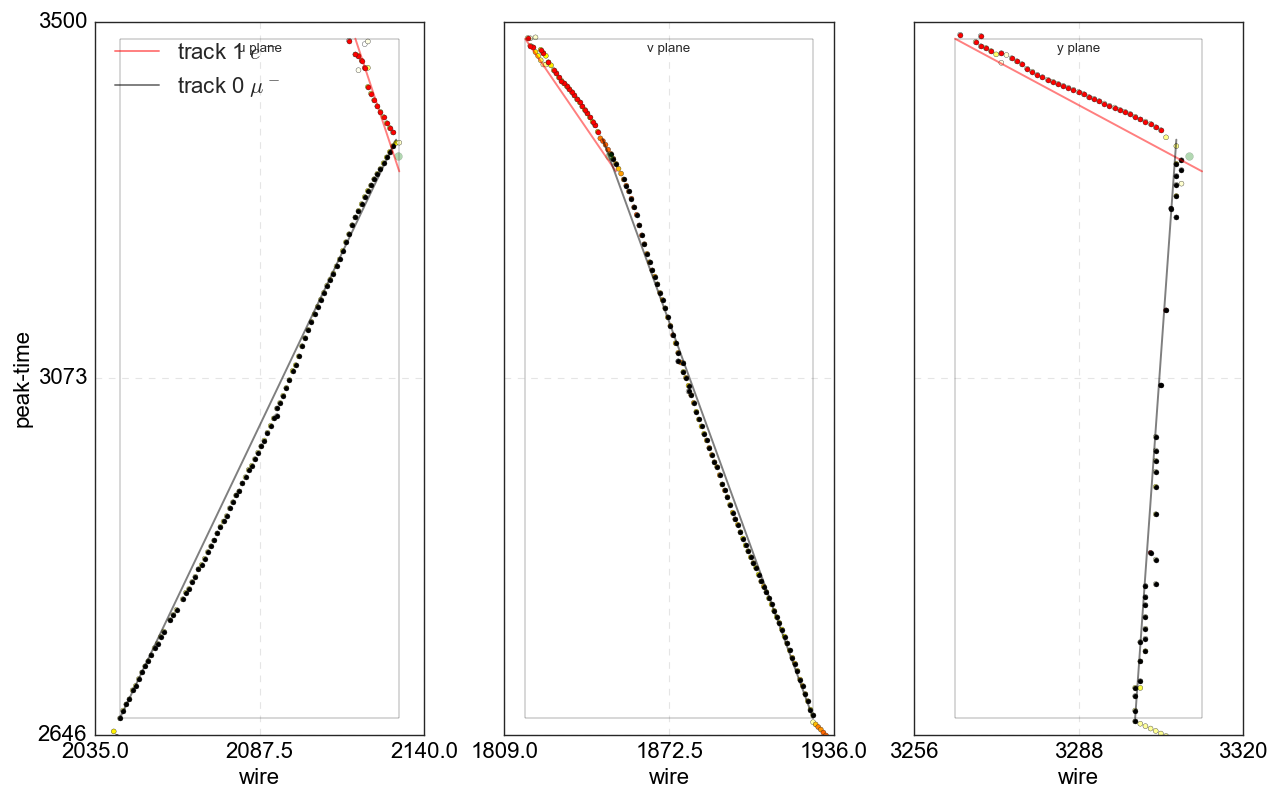

In [1124]:
print 'a mu-e vertex'
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=1 , subrun=2287 , event=45725)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
ratio = perform_tracking( hits, tracks , debug=0 , figsize=(16,10), planes=[0,1,2] )
print ratio

<IPython.core.display.Javascript object>


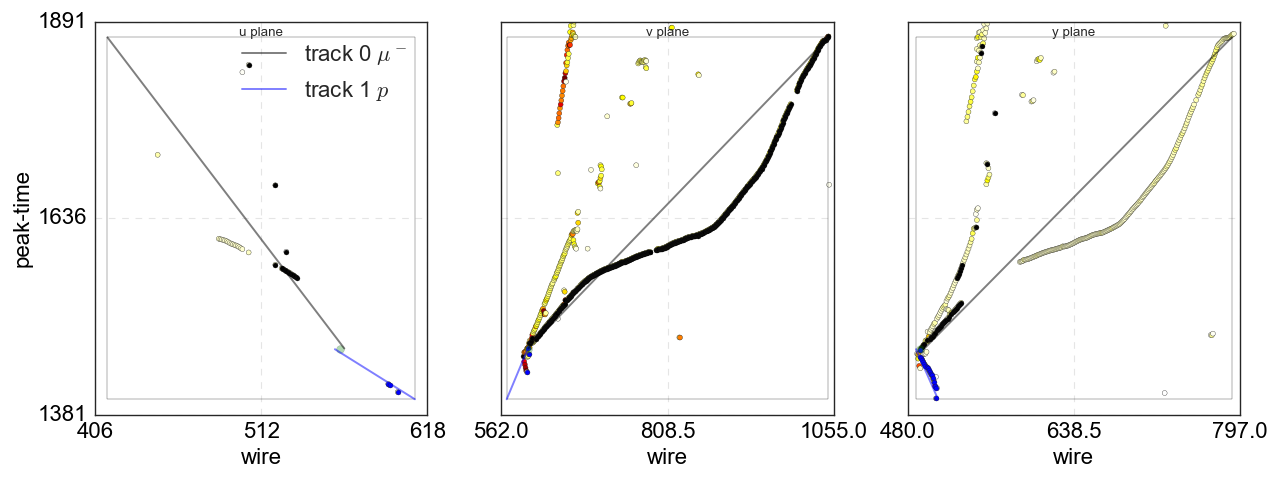

In [1125]:
print 'not a true CC1p'
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=5 , subrun=5752 , event=115039)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
print 'Np,Nn,Npi:',vertex.closest_genie_interaction.Np,vertex.closest_genie_interaction.Nn,vertex.closest_genie_interaction.Npi
ratio = perform_tracking( hits, tracks , debug=0,planes=[0,1,2])
print ratio

<IPython.core.display.Javascript object>


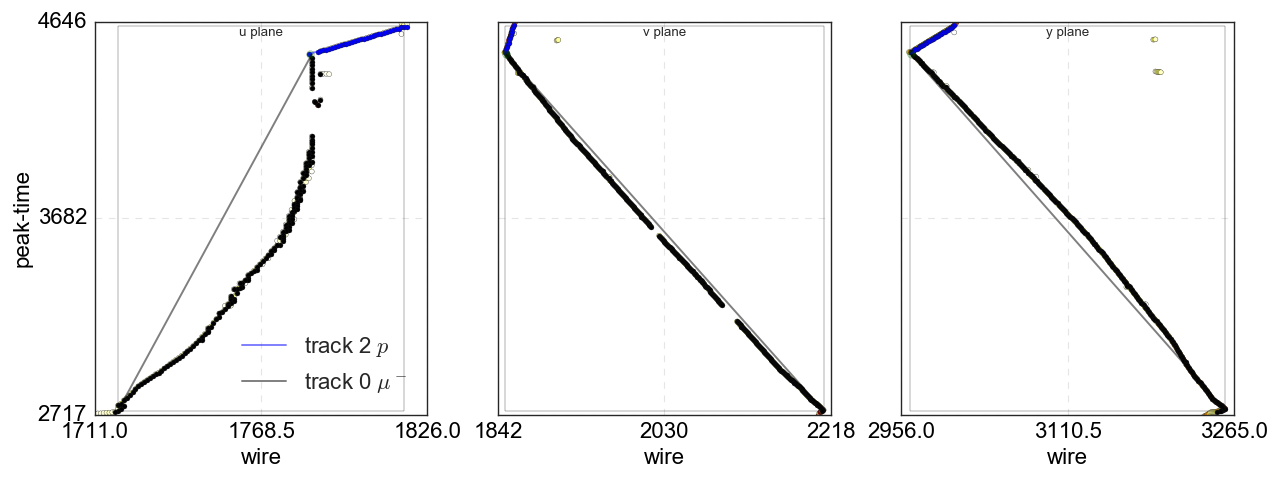

In [1126]:
print 'a true CC1p'
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=4 , subrun=4255 , event=85085)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
# ratio = associate_hits_to_tracks( hits, tracks , debug=2, max_hit_time_track_time_diff=80)
ratio = perform_tracking(hits,tracks,debug=0,planes=[0,1,2])
# ratio = associate_closest_hits_to_tracks( hits, tracks , debug=2 )
print ratio

<IPython.core.display.Javascript object>


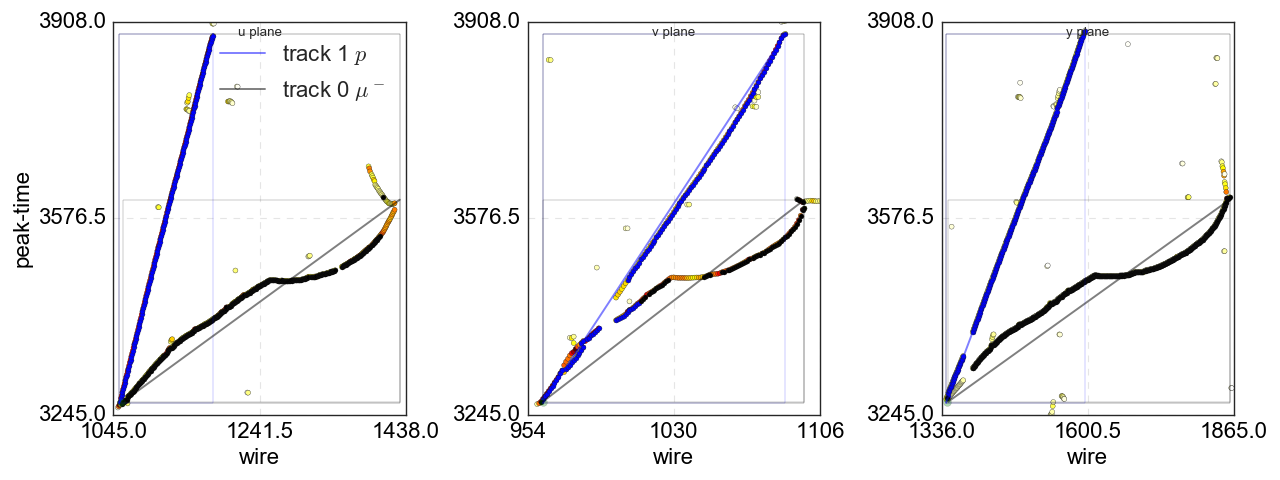

In [1127]:
hits, vertex = get_CC1p_tracks_from_rse(events=events, run=5 , subrun=2916 , event=58319)
tracks = [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]
perform_tracking( hits, tracks , debug=2)
print 'Np,Nn,Npi:',vertex.closest_genie_interaction.Np,vertex.closest_genie_interaction.Nn,vertex.closest_genie_interaction.Npi
# print ratio